```{post} 2023-11-12
:author: Saul
```


# Indexing pushdown

I got this question today, and I thought I would write up some examples to explain the current state of things, for this sort of indexing pushdown:

Q: How would I do a `exp(vec)[idx] -> exp(vec[idx])` rewrite?

A: You can easily write this rewrite to add both expressions to the graph, but it's currently difficult to extract out the right expression over the left one:


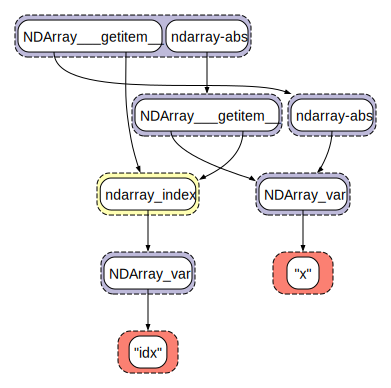

abs(NDArray.var("x")[ndarray_index(NDArray.var("idx"))])
abs(NDArray.var("x"))[ndarray_index(NDArray.var("idx"))]


In [1]:
from __future__ import annotations

from egglog.exp.array_api import *

egraph = EGraph([array_api_module])


@egraph.register
def _pushdown_abs(x: NDArray, idx: IndexKey):
    yield rewrite(abs(x)[idx]).to(abs(x[idx]))


res = abs(NDArray.var("x"))[NDArray.var("idx")]
egraph.register(res)
egraph.run(100)
egraph.display()

for e in egraph.extract_multiple(res, 10):
    print(e)

We see here it extracts out the two objects. If we ask it to just extract out the lowest cost one, it will be non-deterministic which is selected.

See [this issue](https://github.com/egraphs-good/egglog/issues/256#issuecomment-1807185387) on the egglog tracker for how this could be resolved.


---

Another way to resolve this, would be to actually try to define the _semantics_ of these two operations. We can make up a mathematical abstraction for arrays, and define both indexing and the `abs` function in terms of that abstraction. Then when we compose them, we can look at the composition of the abstractions, to see if that normalizing that form to a canonical one can also achieve the predicate pushdown optimization.

In this case, we can pick an abstraction where each array is defined by:

1. A shape `.shape`
2. A dtype `.dtype`
3. A mapping from indices to values `x.index(idx)`. Similar to regular indexing `x[idx]`, but only returns the inner value, not a scalar array, so that the defintion is not recursive.

So in this case, our question would be, what's the shape, dtype, and indexed value of `abs(x)[idx]`?


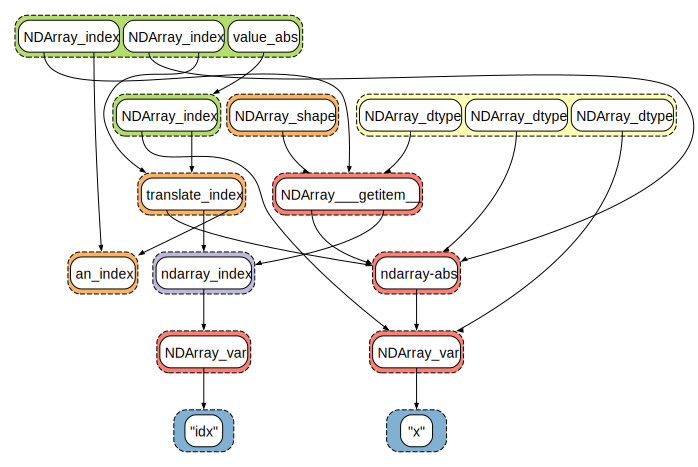

Resulting shapes:
  abs(NDArray.var("x"))[ndarray_index(NDArray.var("idx"))].shape
Resulting dtypes:
  abs(NDArray.var("x"))[ndarray_index(NDArray.var("idx"))].dtype
  abs(NDArray.var("x")).dtype
  NDArray.var("x").dtype
Resulting indexing:
  value_abs(NDArray.var("x").index(translate_index(abs(NDArray.var("x")), ndarray_index(NDArray.var("idx")), an_index())))
  abs(NDArray.var("x"))[ndarray_index(NDArray.var("idx"))].index(an_index())
  abs(NDArray.var("x")).index(translate_index(abs(NDArray.var("x")), ndarray_index(NDArray.var("idx")), an_index()))


In [6]:
egraph = EGraph([array_api_module])


@egraph.function(cost=0)
def value_abs(v: Value) -> Value:
    """Absolute value of a scalar value"""


@egraph.register
def _define_abs(x: NDArray, ti: TupleInt):
    # dtype after taking absolute value is same dtype
    yield rewrite(abs(x).dtype).to(x.dtype)
    # shape after taking absolute value is same shape
    yield rewrite(abs(x).shape).to(x.shape)
    # Indexing into absolute value is same as indexing into original and then taking the absolute value
    yield rewrite(abs(x).index(ti)).to(value_abs(x.index(ti)))


@egraph.function(cost=0)
def translate_index(x: NDArray, y: IndexKey, z: TupleInt) -> TupleInt:
    """Translates indexing `z` into `x[y]` into an indexing directly into `x`"""


@egraph.register
def _define_indexing(x: NDArray, idx: IndexKey, ti: TupleInt):
    # dtype after indexing is same dtype
    yield rewrite(x[idx].dtype).to(x.dtype)
    # indxing is pushed down to source array, after some translation
    yield rewrite(x[idx].index(ti)).to(x.index(translate_index(x, idx, ti)))
    # Shape is more complicated and we will omit for now


@egraph.function
def an_index() -> TupleInt:
    """Some index into an array"""


egraph.register(res.shape, res.dtype, res.index(an_index()))
egraph.run(100)
egraph.display()


print("Resulting shapes:")
for e in egraph.extract_multiple(res.shape, 10):
    print(" ", e)
print("Resulting dtypes:")
for e in egraph.extract_multiple(res.dtype, 10):
    print(" ", e)
print("Resulting indexing:")
for e in egraph.extract_multiple(res.index(an_index()), 10):
    print(" ", e)

For the same reason as above, if we extract out the lowest cost one, it will be non-deterministic which is selected (at least for indexing), but if we look at all of them, we can see that the `dtype` is pushed down to the inner value, and also the indexing is as well.
